# Visualizing EIANN network structure

:::{note}
🚧 **Work in Progress:** This documentation site is currently under construction. Content may change frequently.
:::

In this tutorial, we will show some examples of what we can analyze about the internal structure of an EIANN network after we have  applied our chosen learning algorithm and trained it.

In [1]:
import EIANN.EIANN as eiann
from EIANN import utils as ut
eiann.plot.update_plot_defaults()
root_dir = ut.get_project_root()
%load_ext autoreload
%autoreload 2

/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/utils/data_utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


For convenience, we've packaged the code for loading the MNIST dataloaders into a separate function:

In [2]:
# 1. Loading the MNIST dataset
train_dataloader, val_dataloader, test_dataloader, data_generator = ut.get_MNIST_dataloaders()

Now we can load the network that was trained in the previous tutorial:

In [3]:
# Load network object from pickle file
network_name = "example_EI_network"
network = ut.load_network(path= f"{root_dir}/EIANN/saved_networks/mnist/{network_name}.pkl")

Loading network from '/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/saved_networks/mnist/example_EI_network.pkl'
Network successfully loaded from '/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/saved_networks/mnist/example_EI_network.pkl'


## 1. Analyze population activities

To get a first overview of how the network is representing different stimuli categories, we can plot the average activity of each unit in the network across the different stimulus categories (in this case MNIST digit labels). This gives us a sense of how selective units are to particular image categories and how distributed or sparse the representation is at the population level.

Batch accuracy = 94.69000244140625%


/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/plot.py:972: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


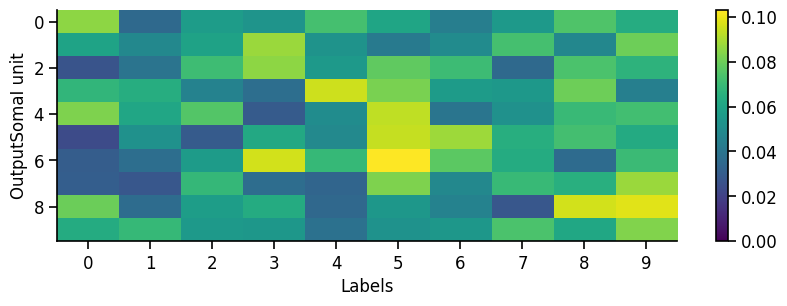

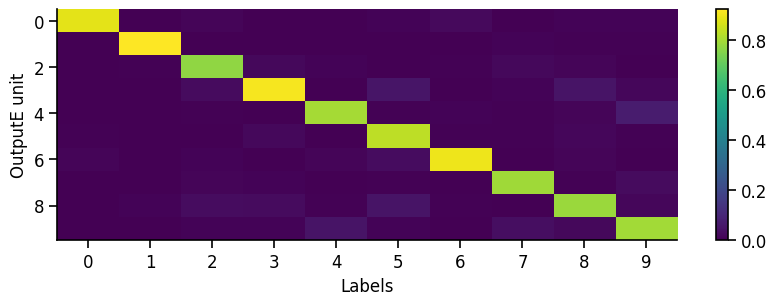

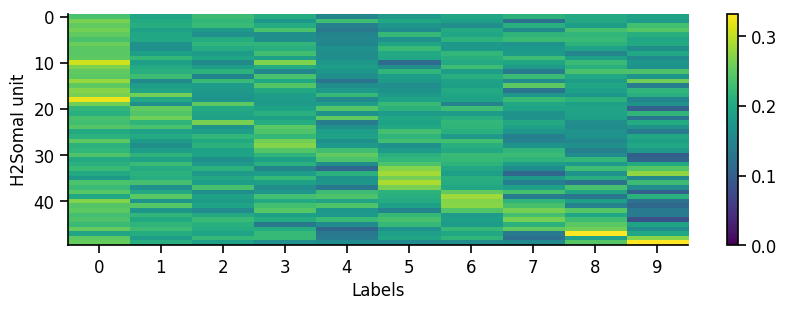

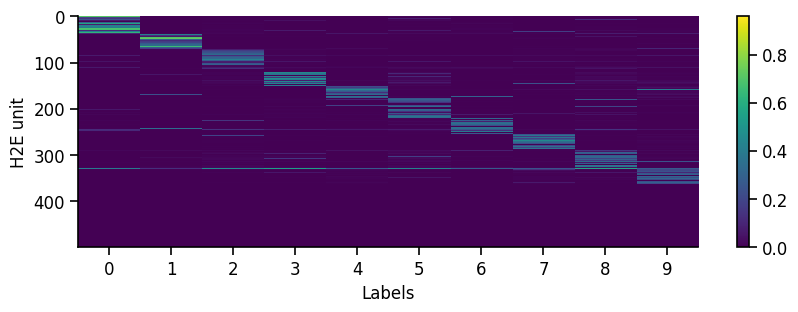

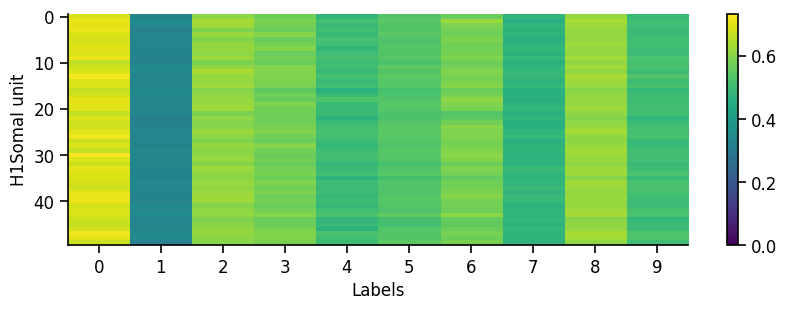

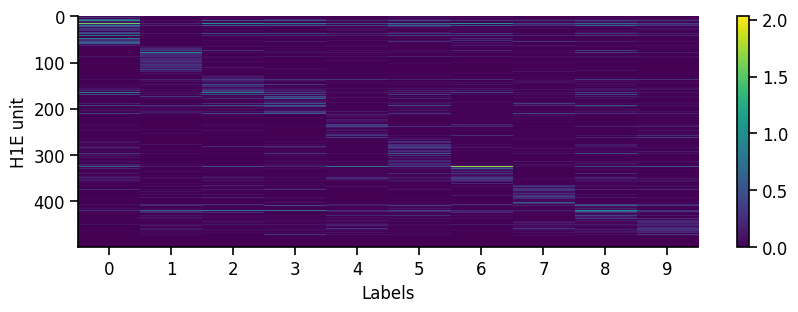

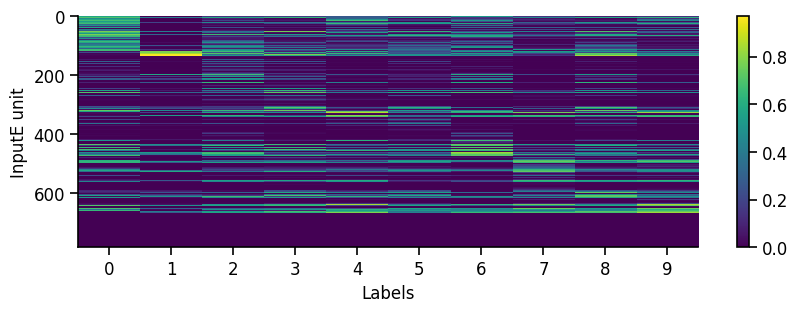

In [4]:
eiann.plot.plot_batch_accuracy(network, test_dataloader, population='all')

If our network has recurrent connections (such as in an EI network), we can also visualize the network temporal dynamics within each sample. This gives us a sense of how stable the network is, or if there are significant oscillations that might affect our learning algorithm. For example, if there are separate recurrent E and I populations we might generally expect some initial oscillations when we present a new stimulus, which should eventually equilibrate to a stable state (depending on the exact values/strength of the recurrent connections).

torch.Size([18, 10000, 500])


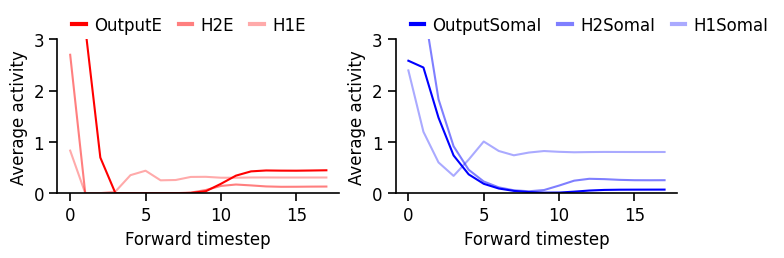

In [53]:
pop_dynamics_dict = ut.compute_test_activity_dynamics(network, test_dataloader, plot=True, normalize=False) # We will evaluate the network dynamics by presenting the test dataset and recording the neuron activity.
print(pop_dynamics_dict['H1E'].shape) # Since we are store the dynamics here, each population should have activity of shape (timesteps, data samples, neurons)

At the population level, we can quantify various aspects of the learned representation, such as the sparsity (how many neurons are active at any given time) and the individual selectivty (how selective each neuron is to a particular stimulus).

/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/plot.py:374: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


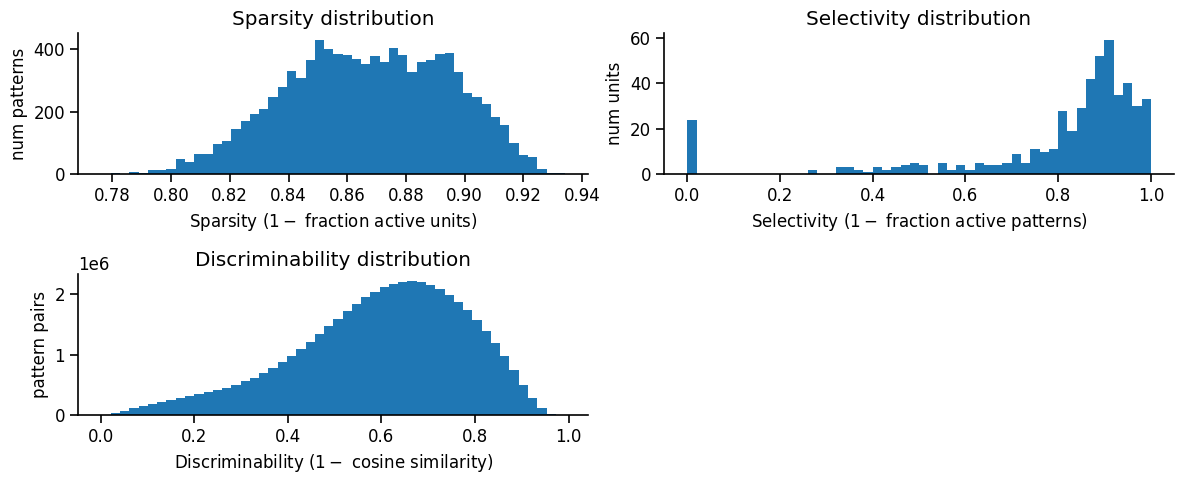

In [ ]:
metrics_dict = ut.compute_representation_metrics(population=network.H1.E, dataloader=test_dataloader, plot=True)

If we want a more in-depth look at how individual neurons are behaving and which features of the input they have learned, we can generate a visualization of all the "receptive fields" for a given population. This is done by optimizing inputs to maximize the activity of a given neuron.

Optimizing receptive field images...


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/plot.py:827: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax[1].axis('off')


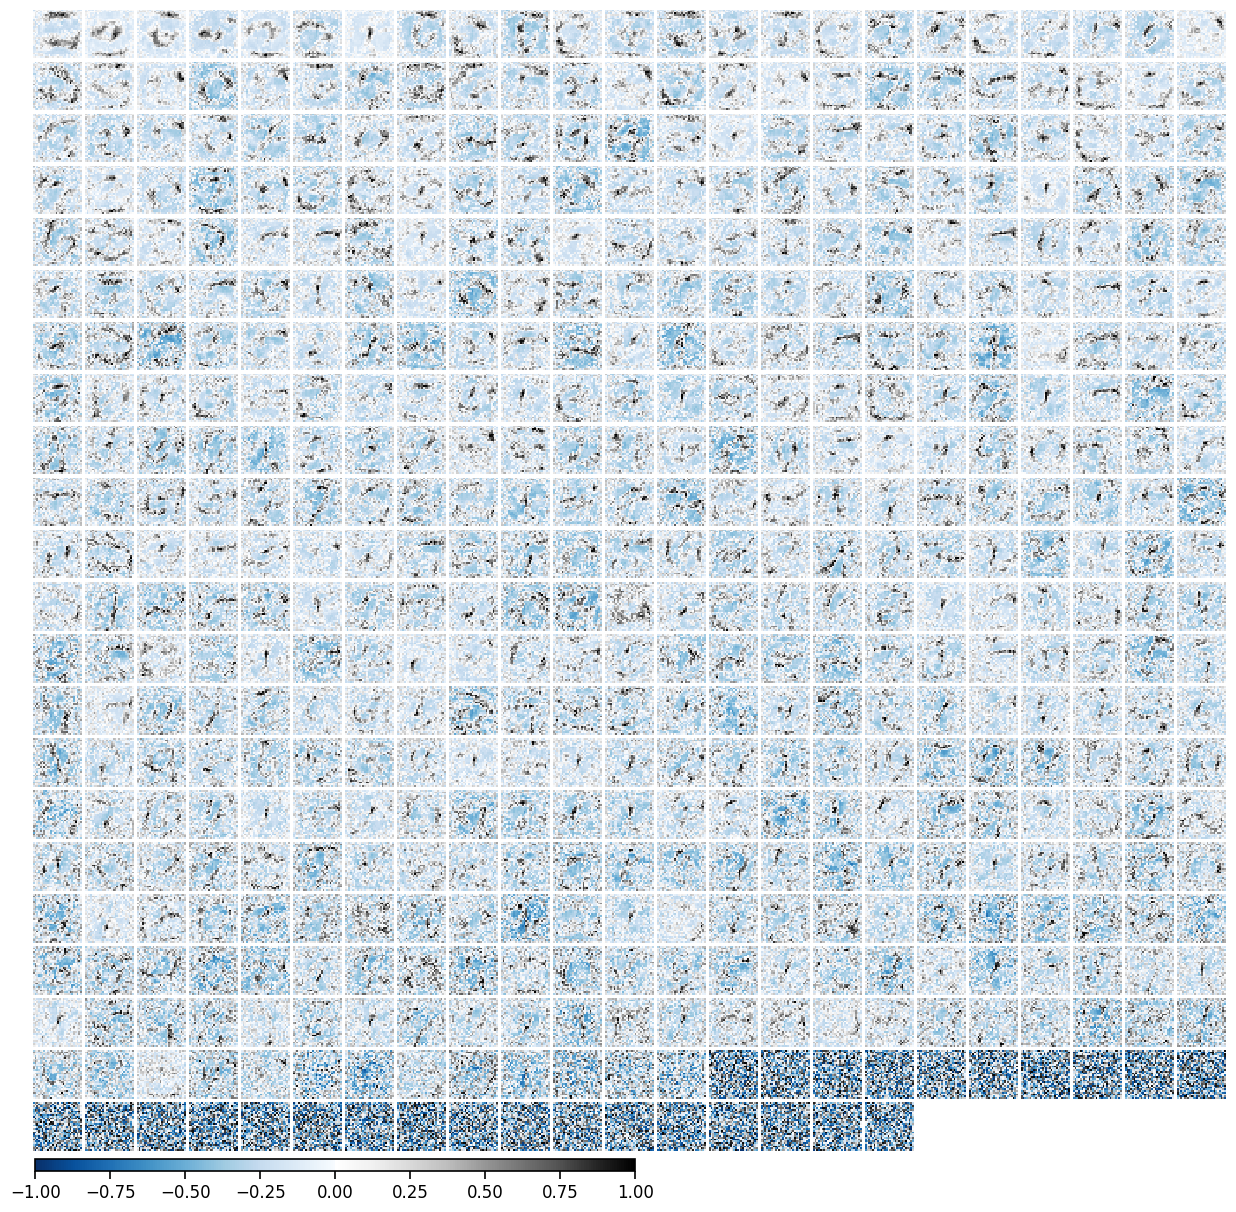

In [8]:
receptive_fields = ut.compute_maxact_receptive_fields(network.H1.E, test_dataloader=test_dataloader)
eiann.plot.plot_receptive_fields(receptive_fields, sort=True)

In this example, we can see that in the Excitatory cells of the first hidden layer (H1.E), most neurons have learned to form simple receptive fields that are similar to Gabor filters and sensitive to particular orientations and spatial frequencies within different regions of the image.

To compare this more quantitatively across different neural networks, we can quantify how 'structured' the receptive fields are by measuring their spatial autocorrelations using a metric called [Morans I](https://en.wikipedia.org/wiki/Moran%27s_I).

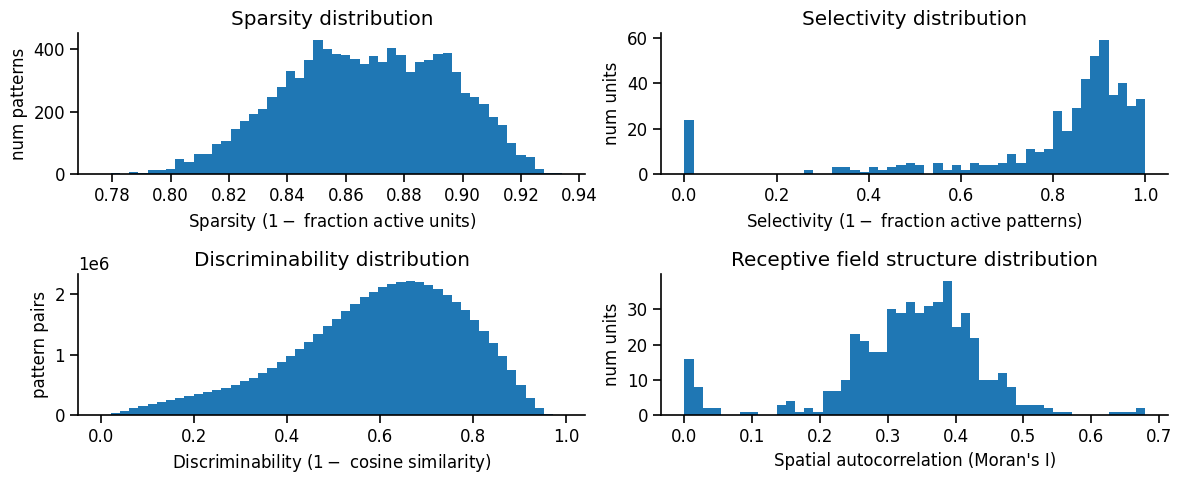

In [18]:
metrics_dict = ut.compute_representation_metrics(population=network.H1.E, dataloader=test_dataloader, receptive_fields=receptive_fields, plot=True)

Another way to look at the learned representations is through a representational similarity analysis (RSA), where we can compare how similar the population representations are for different stimuli.

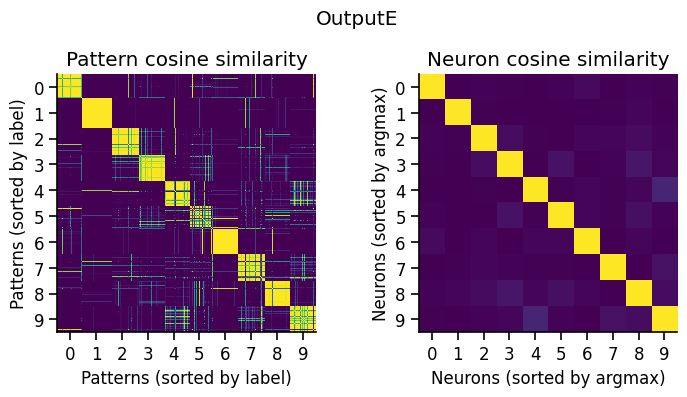

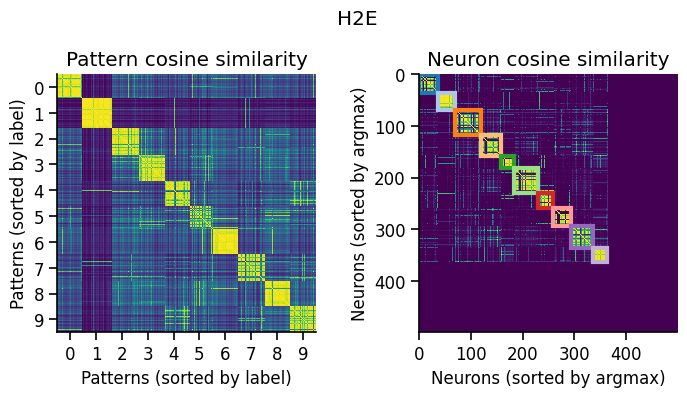

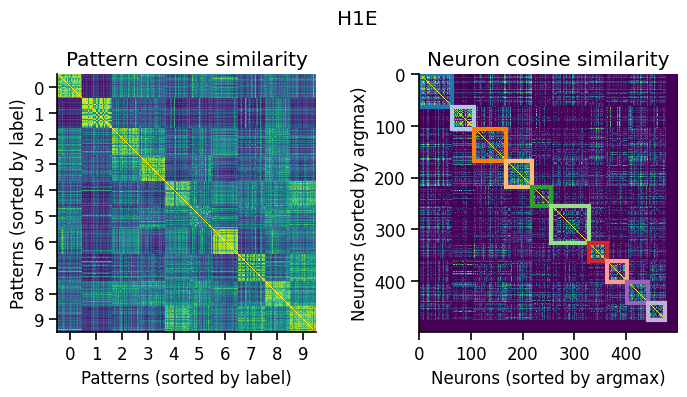

In [61]:
pop_activity_dict, pattern_labels, unit_labels_dict = ut.compute_test_activity(network, test_dataloader, class_average=False, sort=True)
pattern_similarity_matrix_dict, neuron_similarity_matrix_dict = ut.compute_representational_similarity_matrix(pop_activity_dict, pattern_labels, unit_labels_dict, population='E', plot=True)